# Does faculty salary vary by gender?

## Set up

Before getting started, the only addtional library you should have to install (that did not come with the anaconda python distribution) is `seaborn`, a package for visualization:

```
pip install seaborn
```

Let's begin by reading in some data from [this course website](http://data.princeton.edu/wws509/datasets/#salary). Columns included are:

- **sx** = Sex, coded 1 for female and 0 for male
- **rk** = Rank, coded
    - 1 for assistant professor,
    - 2 for associate professor, and
    - 3 for full professor
- **yr** = Number of years in current rank
- **dg** = Highest degree, coded 1 if doctorate, 0 if masters
- **yd** = Number of years since highest degree was earned
- **sl** = Academic year salary, in dollars.

In [248]:
# Set up
import numpy as np
import pandas as pd
import seaborn as sns # for visualiation
import urllib2 # to load data
from scipy.stats import ttest_ind # t-tests
import statsmodels.formula.api as smf # linear modeling
import matplotlib.pyplot as plt # plotting
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline 

In [249]:
# Read data from URL
file = urllib2.urlopen('http://data.princeton.edu/wws509/datasets/salary.dat')
headers = file.next()
df = pd.DataFrame(l.rstrip().split() for l in file)
df.columns = headers.rstrip().split()
df['sl'] = df['sl'].astype(float) # Make sure salary is float
df['yr'] = df['yr'].astype(int) # Make sure year is int is float
df['yd'] = df['yd'].astype(int) # Make sure salary is float

## Descriptive statistics

Here, you should explore dimensions of your dataframe -- compute measure of interest such as column means, correlations, numbers of observations by group, etc.

In [250]:
# Number of males/females in the dataset
df.groupby('sx').size()

sx
female    14
male      38
dtype: int64

In [251]:
# Salary by sex
df[['sx', 'sl']].groupby('sx').agg('mean')

,sl
sx,
female,21357.142857
male,24696.789474


# Test for a difference in means by gender
Use a t-test to see if there is a significant difference in means

In [252]:
# Separate into different arrays by sex
males = df[df['sx'] == 'male'] 
females = df[df['sx'] == 'female']

In [253]:
# Test for difference
ttest_ind(males[['sl']], females[['sl']]) # not significant!

Ttest_indResult(statistic=array([ 1.84744028]), pvalue=array([ 0.07060394]))

## Difference in means by rank (full v.s. not full)

In [254]:
# Separate into different arrays by sex
full = df[df['rk'] == 'full']
not_full = df[df['rk'] != 'full']

# Test for difference
ttest_ind(full[['sl']], not_full[['sl']]) # significant!
print(np.mean(not_full['sl']), np.mean(full['sl']))

(20134.34375, 29658.95)


In [297]:
# Use the ANOVA method to test for differences in means across multiple groups
from scipy import stats
stats.f_oneway(df[df.rk == 'full'].sl, df[df.rk == 'associate'].sl, df[df.rk == 'assistant'].sl)

TypeError: count() takes exactly one argument (0 given)

## Explore salary distributions by sex, rank

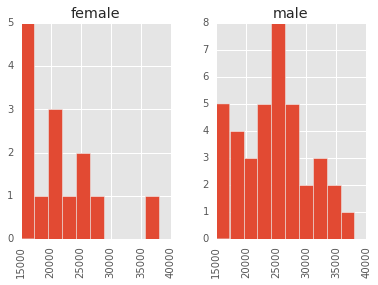

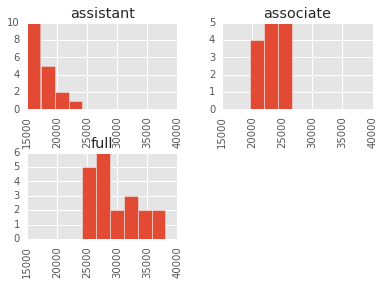

In [255]:
# Histograms of each distribution
import matplotlib.pyplot as plt
min = np.min(df['sl'])
max = np.max(df['sl'])
plt.figure(figsize=(10,5))
df['sl'].hist(by=df['sx'], range=[min, max])
df['sl'].hist(by=df['rk'], range=[min, max])
plt.show()

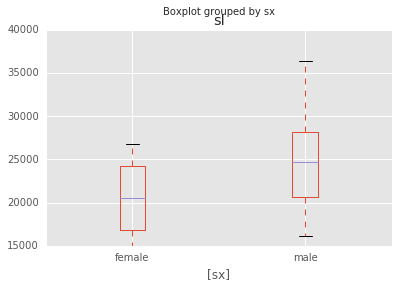

In [256]:
# View distributions in a boxplot
df[['sx', 'sl']].boxplot(by='sx')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11fc42c90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x126516e10>], dtype=object)

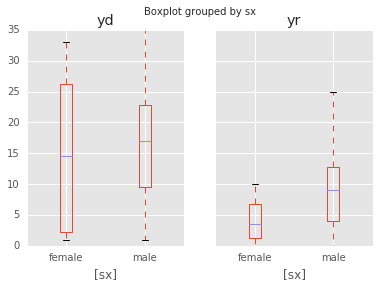

In [257]:
# Do number of years vary by gender?
df[['sx', 'yr', 'yd']].boxplot(by='sx')

## Explore bivariate relationships visually


Number of years since degree versus salary

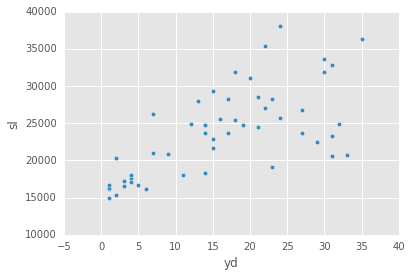

In [258]:
df.plot('yd', 'sl', kind="scatter")

Number of years in current position versus salary

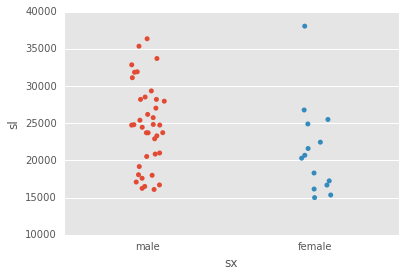

In [263]:
# Show relationship b/w each variable and the ourcome
sns.stripplot(x="sx", y="sl", data=df, jitter=True);

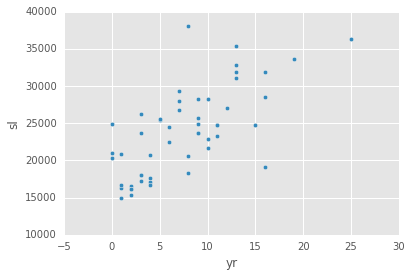

In [259]:
df.plot('yr', 'sl', kind="scatter")

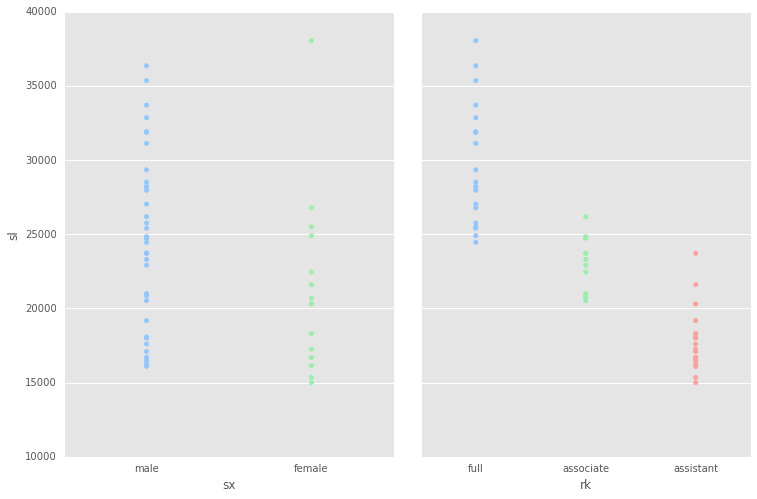

In [264]:
# Categorical variables
g = sns.PairGrid(df,
                 x_vars=["sx",'rk'],
                 y_vars=["sl"],
                 aspect=.75, size=7)
g.map(sns.stripplot, palette="pastel");

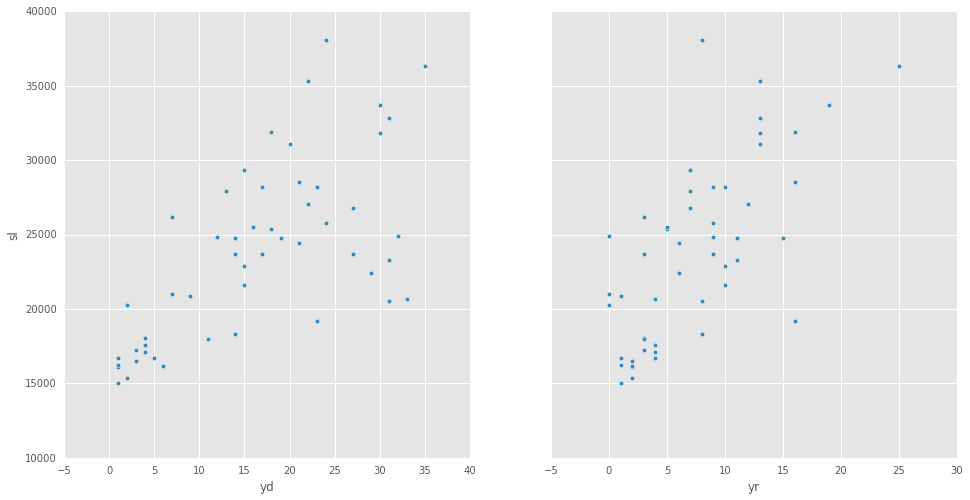

In [267]:
# Salary by continuous variables (yd, yr)
fig, axs = plt.subplots(1, 2, sharey=True)
df.plot(kind='scatter', x='yd', y='sl', ax=axs[0], figsize=(16, 8))
df.plot(kind='scatter', x='yr', y='sl', ax=axs[1])

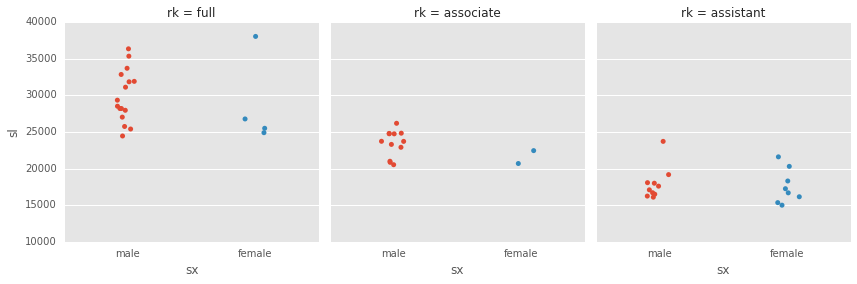

In [265]:
# Sex by rank!
sns.factorplot(x="sx", y="sl", 
               col="rk", data=df, kind="strip", jitter=True);

## Simple linear regression: what is the expected salary increase for each additional year in your current position (`yr`)

In [260]:
# create a fitted model in one line
lm = smf.ols(formula='sl ~ yd', data=df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sl   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     41.82
Date:                Fri, 03 Feb 2017   Prob (F-statistic):           4.10e-08
Time:                        00:13:18   Log-Likelihood:                -509.13
No. Observations:                  52   AIC:                             1022.
Df Residuals:                      50   BIC:                             1026.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    1.75e+04   1149.700     15.223      0.000      1.52e+04  1.98e+04
yd           390.6451     60.411      6.466      0.000       269.306   511.984
==============================================================================
Omnibus:                        0.572   Durbin-Watson:                   1.319
Prob(Omnibus):                  0.751   Jarque-Bera (JB):                0.237
Skew:                           0.160   Prob(JB):                        0.888
Kurtosis:                       3.081   Cond. No.                         35.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [261]:
# Make predictions using the linear model
df['predictions'] = lm.predict()

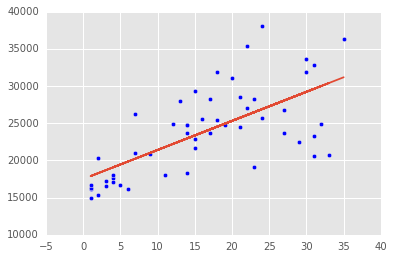

In [262]:
# How well does our line fit our data?
plt.scatter(df.yd, df.sl)
plt.plot(df.yd, df.predictions)
plt.show()

## Multiple Regression

Predict using **multiple** independent variables

          yd        yr
yd  1.000000  0.638776
yr  0.638776  1.000000


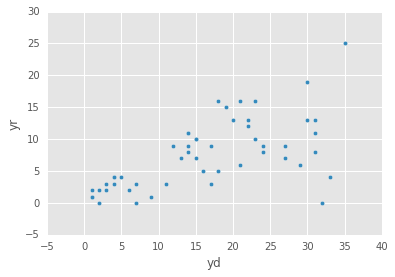

In [266]:
# Just to check: yd and yr are correlated
print(df[['yd', 'yr']].corr())
df.plot(kind='scatter', x='yd', y='yr')

In [270]:
lm_mult = smf.ols(formula='sl ~ yd + sx + rk + yr + dg', data=df).fit()
lm_mult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sl   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     44.24
Date:                Fri, 03 Feb 2017   Prob (F-statistic):           2.87e-17
Time:                        00:13:50   Log-Likelihood:                -474.72
No. Observations:                  52   AIC:                             963.4
Df Residuals:                      45   BIC:                             977.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept        1.691e+04    816.442     20.715      0.000      1.53e+04  1.86e+04
sx[T.male]      -1166.3731    925.569     -1.260      0.214     -3030.565   697.818
rk[T.associate]  5292.3608   1145.398      4.621      0.000      2985.411  7599.311
rk[T.full]       1.112e+04   1351.772      8.225      0.000      8396.155  1.38e+04
dg[T.masters]    1388.6133   1018.747      1.363      0.180      -663.248  3440.475
yd               -124.5743     77.486     -1.608      0.115      -280.640    31.491
yr                476.3090     94.914      5.018      0.000       285.143   667.475
==============================================================================
Omnibus:                       26.102   Durbin-Watson:                   1.742
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.617
Skew:                           1.462   Prob(JB):                     1.38e-12
Kurtosis:                       7.082   Cond. No.                         111.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [271]:
df['mult_preds'] = lm_mult.predict()

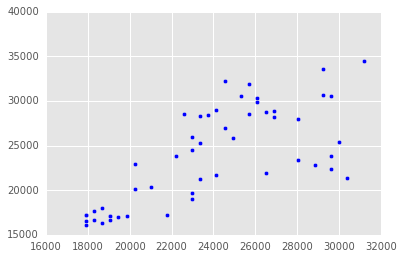

In [272]:
# How do our predictions compare
plt.scatter(df.predictions, df.mult_preds)

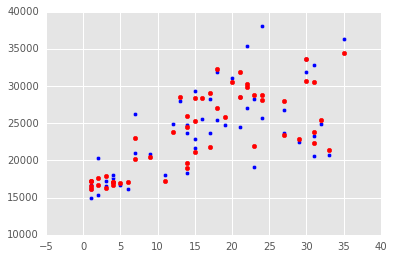

In [273]:
# How do our predictions perform (over years since degree)
plt.scatter(df.yd, df.sl)
plt.scatter(df.yd, df.mult_preds, color='red')
plt.show()

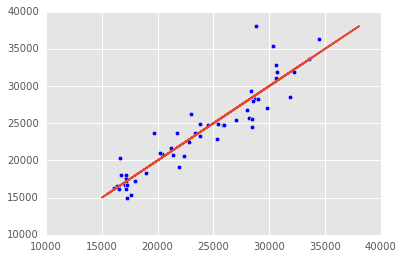

In [274]:
# Compare predictions to observations
plt.scatter(df.mult_preds, df.sl)
plt.plot(df.sl, df.sl)
plt.show()

In [275]:
# What are the r-squared values of the models?
print(lm.rsquared, lm_mult.rsquared) # explain the same amount of variance?

(0.45542813458360276, 0.85504057972251624)


In [276]:
# Let's add a model that's just sex and years since graduation
lm_mult_sex_only = smf.ols(formula='sl ~ yd + C(sx)', data=df).fit()
lm_mult_sex_only.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sl   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     23.83
Date:                Fri, 03 Feb 2017   Prob (F-statistic):           5.91e-08
Time:                        00:13:56   Log-Likelihood:                -507.27
No. Observations:                  52   AIC:                             1021.
Df Residuals:                      49   BIC:                             1026.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      1.578e+04   1438.330     10.973      0.000      1.29e+04  1.87e+04
C(sx)[T.male]  2572.5343   1349.082      1.907      0.062      -138.548  5283.616
yd              380.6938     59.109      6.440      0.000       261.909   499.479
==============================================================================
Omnibus:                        3.822   Durbin-Watson:                   1.283
Prob(Omnibus):                  0.148   Jarque-Bera (JB):                2.919
Skew:                           0.368   Prob(JB):                        0.232
Kurtosis:                       3.897   Cond. No.                         56.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [277]:
print(lm.rsquared, lm_mult_sex_only.rsquared)

(0.45542813458360276, 0.49304792719667823)


In [278]:
lm_mult_sex_only.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sl   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     23.83
Date:                Fri, 03 Feb 2017   Prob (F-statistic):           5.91e-08
Time:                        00:13:58   Log-Likelihood:                -507.27
No. Observations:                  52   AIC:                             1021.
Df Residuals:                      49   BIC:                             1026.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      1.578e+04   1438.330     10.973      0.000      1.29e+04  1.87e+04
C(sx)[T.male]  2572.5343   1349.082      1.907      0.062      -138.548  5283.616
yd              380.6938     59.109      6.440      0.000       261.909   499.479
==============================================================================
Omnibus:                        3.822   Durbin-Watson:                   1.283
Prob(Omnibus):                  0.148   Jarque-Bera (JB):                2.919
Skew:                           0.368   Prob(JB):                        0.232
Kurtosis:                       3.897   Cond. No.                         56.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

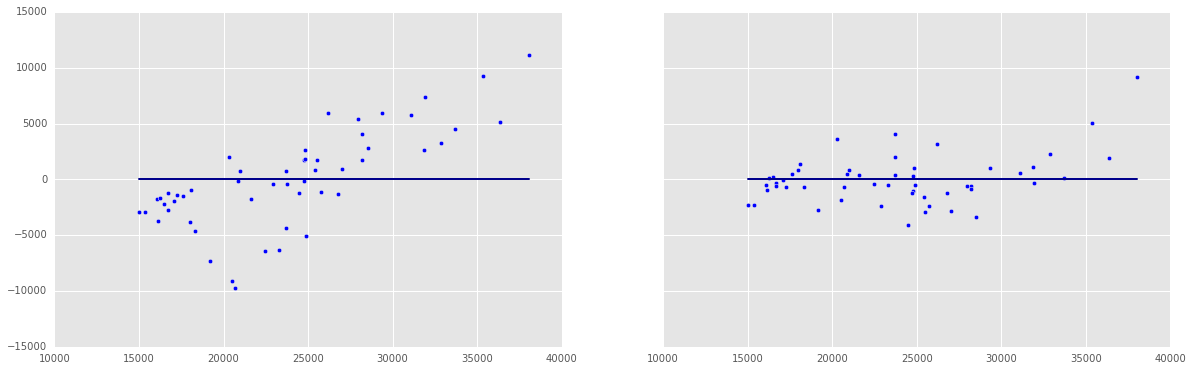

In [283]:
# Plot the residuals with a center line
df['lm_resids'] = df.sl - df.predictions
df['lm_mult_resids'] = df.sl - df.mult_preds
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 6))
ax1.scatter(df.sl, df.lm_resids)
ax1.plot((np.min(df.sl), np.max(df.sl)), (0,0),color='darkblue', lw=2)
ax2.scatter(df.sl, df.lm_mult_resids)
ax2.plot((np.min(df.sl), np.max(df.sl)), (0,0),color='darkblue', lw=2)
plt.show()

As shown above, this model clearly **over predicts** low salaries and **under predicts** higher salaries. Clearly, we're missing something that **explains variation** besides the number of years.